In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Hyperparameters
batch_size = 512
epochs = 200
learning_rate = 1e-3

# Generate two Gaussians dataset in corners (4,4) and (4,-4)
X, _ = make_blobs(n_samples=10000, centers=[(4,4), (4,-4)], cluster_std=0.5, random_state=42)
X = torch.tensor(X, dtype=torch.float32)

# Simple MLP model for vector field
class VectorFieldMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2 + 1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x, t):
        x = torch.cat([x, t], dim=-1)
        return self.net(x)

def compute_alpha_t(t):
    return 1 - t, -1

def compute_sigma_t(t):
    return t, 1

# Training function
def train(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for x_0 in tqdm(dataloader):
        x_0 = x_0[0].to(device)
        optimizer.zero_grad()

        # Generate noise
        x_1 = torch.randn_like(x_0)
        
        # Sample t uniformly
        t = torch.rand(x_0.shape[0], device=device)
        t = t.unsqueeze(-1)
        alpha_t, d_alpha_t = compute_alpha_t(t)
        sigma_t, d_sigma_t = compute_sigma_t(t)
        # Interpolate between x_0 and x_1
        x_t = alpha_t * x_0 + sigma_t * x_1
        
        # Compute vector field
        v_theta = model(x_t, t)
        
        # Compute loss
        loss = torch.mean(torch.sum((v_theta - (d_alpha_t * x_0 + d_sigma_t * x_1))**2, dim=-1))

        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)


# Initialize model, optimizer, and dataloader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VectorFieldMLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
dataloader = DataLoader(TensorDataset(X), batch_size=batch_size, shuffle=True)

# Training loop
losses = []
for epoch in range(epochs):
    loss = train(model, dataloader, optimizer, device)
    losses.append(loss)
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 253.03it/s]


Epoch 50/200, Loss: 6.2146


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 277.94it/s]


Epoch 100/200, Loss: 5.6612


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 277.91it/s]


Epoch 150/200, Loss: 5.6522


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 270.01it/s]

Epoch 200/200, Loss: 5.7407


  0%|                                                                                                        | 0/50 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 754.48it/s]


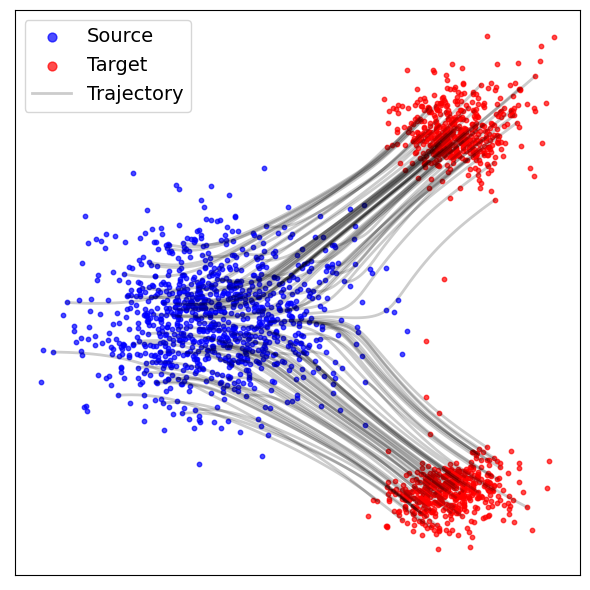

In [19]:
# Plot the trajectories using the learnt vector field
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Generate source samples from the same distribution as training data
X_source = torch.randn(1000, 2)

# Visualize trajectories from source to target
@torch.no_grad()
def plot_trajectories(model, device, source_samples, n_steps=50, n_trajectories=50):
    """Plot trajectories from source samples using the learned vector field."""
    model.eval()
    
    # Convert all source samples to tensor
    x_all = source_samples.to(device)
    n_samples = x_all.shape[0]
    
    # Select subset for trajectories
    trajectory_indices = np.random.choice(n_samples, n_trajectories, replace=False)
    x_trajectory = x_all[trajectory_indices]
    
    # Initialize array to store trajectory points
    trajectories = [x_trajectory.cpu().numpy()]
    
    # Generate trajectory for the subset
    dt = 1.0 / n_steps
    for step in tqdm(range(n_steps)):
        t = torch.ones(n_trajectories, device=device) * (1 - step * dt)
        t = t.unsqueeze(-1)
        v = model(x_trajectory, t)
        x_trajectory = x_trajectory - v * dt
        trajectories.append(x_trajectory.cpu().numpy())
    
    # Convert to numpy array for easier indexing
    trajectories = np.array(trajectories)
    
    # Get final points for all samples
    final_points = []
    with torch.no_grad():
        x = x_all.clone()
        dt = 1.0 / n_steps
        for step in tqdm(range(n_steps)):
            t = torch.ones(n_samples, device=device) * (1 - step * dt)
            t = t.unsqueeze(-1)
            v = model(x, t)
            x = x - v * dt
        final_points = x.cpu().numpy()
    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot all source points
    ax.scatter(source_samples.cpu().numpy()[:, 0], source_samples.cpu().numpy()[:, 1], 
               c='blue', s=10, alpha=0.7, label='Source')
    
    # Plot all final points (target)
    ax.scatter(final_points[:, 0], final_points[:, 1], 
               c='red', s=10, alpha=0.7, label='Target')
    
    # Plot trajectories only for the subset
    # Add one trajectory to the legend
    ax.plot(trajectories[:, 0, 0], trajectories[:, 0, 1], 'k-', linewidth=2.0, alpha=0.2, label='Trajectory')
    
    # Plot the rest of the trajectories without adding to legend
    for i in range(1, n_trajectories):
        points = trajectories[:, i, :]
        ax.plot(points[:, 0], points[:, 1], 'k-', linewidth=2.0, alpha=0.2)
    
    # ax.set_title('Trajectories from Source to Target')
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Increase font size and marker size in legend
    legend = ax.legend(prop={'size': 14}, markerscale=2.0)
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('flow_matching_trajectories.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return final_points  # Return the final points

# Plot trajectories using source samples (only 100 trajectories but all points)
generated_samples = plot_trajectories(model, device, X_source, n_trajectories=100)



In [47]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch

# Sampling function with animation
@torch.no_grad()
def sample(model, n_samples, device, source_samples, target_samples, steps=100):
    model.eval()
    x = torch.tensor(source_samples, dtype=torch.float32).to(device)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.title(r"Simulation using velocity, $v_t$", fontsize=20, y=1.05,
              bbox=dict(facecolor='yellow', alpha=0.5, edgecolor='none'))  # Add LaTeX title here
    scatter = ax.scatter([], [], s=25, c='red', alpha=0.7, label='Generated')
    source_scatter = ax.scatter(source_samples[:, 0], source_samples[:, 1], s=30, c='blue', alpha=0.3, label='Source')
    target_scatter = ax.scatter(target_samples[:, 0], target_samples[:, 1], s=30, c='green', alpha=0.3, label='Target')
    
    # Set axis limits based on the data
    all_data = np.vstack((source_samples, target_samples))
    x_min, x_max = all_data[:, 0].min(), all_data[:, 0].max()
    y_min, y_max = all_data[:, 1].min(), all_data[:, 1].max()
    margin = 0.05 * max(x_max - x_min, y_max - y_min)  # Reduced margin
    ax.set_xlim(x_min - margin, x_max + margin)
    ax.set_ylim(y_min - margin, y_max + margin)
    
    ax.legend(loc='lower left', fontsize=20)
    
    # Remove axis and ticks
    ax.axis('off')
    
    # Draw lines between initial and final states
    lines = [ax.plot([], [], color='red', alpha=0.1, linewidth=0.5)[0] for _ in range(n_samples)]
    
    dt = 1.0 / steps
    
    def update(frame):
        nonlocal x
        if frame <= steps:
            t = torch.ones(n_samples, device=device) * (1 - frame * dt)
            t = t.unsqueeze(-1)
            v = model(x, t)
            x = x - v * dt
            
            scatter.set_offsets(x.cpu().numpy())
        
        # Update lines
        for i, line in enumerate(lines):
            line.set_data([source_samples[i, 0], x[i, 0].cpu()], [source_samples[i, 1], x[i, 1].cpu()])
        
        return scatter, *lines
    
    anim = animation.FuncAnimation(fig, update, frames=steps+20, interval=50, blit=True)
    
    # Save as GIF with tight layout
    plt.tight_layout()
    anim.save('flow_matching_process_titled.gif', writer='pillow', fps=30)
    plt.close(fig)
    
    return x

# Generate source and target samples
source_samples = torch.randn(2000, 2).numpy()
target_samples = X.numpy()[:2000]

# Generate samples and create animation
samples = sample(model, 2000, device, source_samples, target_samples)

# Plot loss with increased font and tick size
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses, linewidth=3)
plt.title("Flow Matching Training Loss", fontsize=20)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add red dotted line at minimum value
min_loss = min(losses)
plt.axhline(y=min_loss, color='red', linestyle=':', linewidth=2)

# Add text 'L_flow > 0'
plt.text(epochs/2, min_loss*1.1, r'$L_\mathrm{flow} > 0$', fontsize=16, 
         horizontalalignment='center', verticalalignment='bottom')

plt.tight_layout()
plt.savefig('flow_matching_training_loss.png', dpi=300, bbox_inches='tight')
plt.close()

print("Flow Matching process animation saved as 'flow_matching_process.gif'")
print("Flow Matching training loss plot saved as 'flow_matching_training_loss.png'")



Flow Matching process animation saved as 'flow_matching_process.gif'
Flow Matching training loss plot saved as 'flow_matching_training_loss.png'


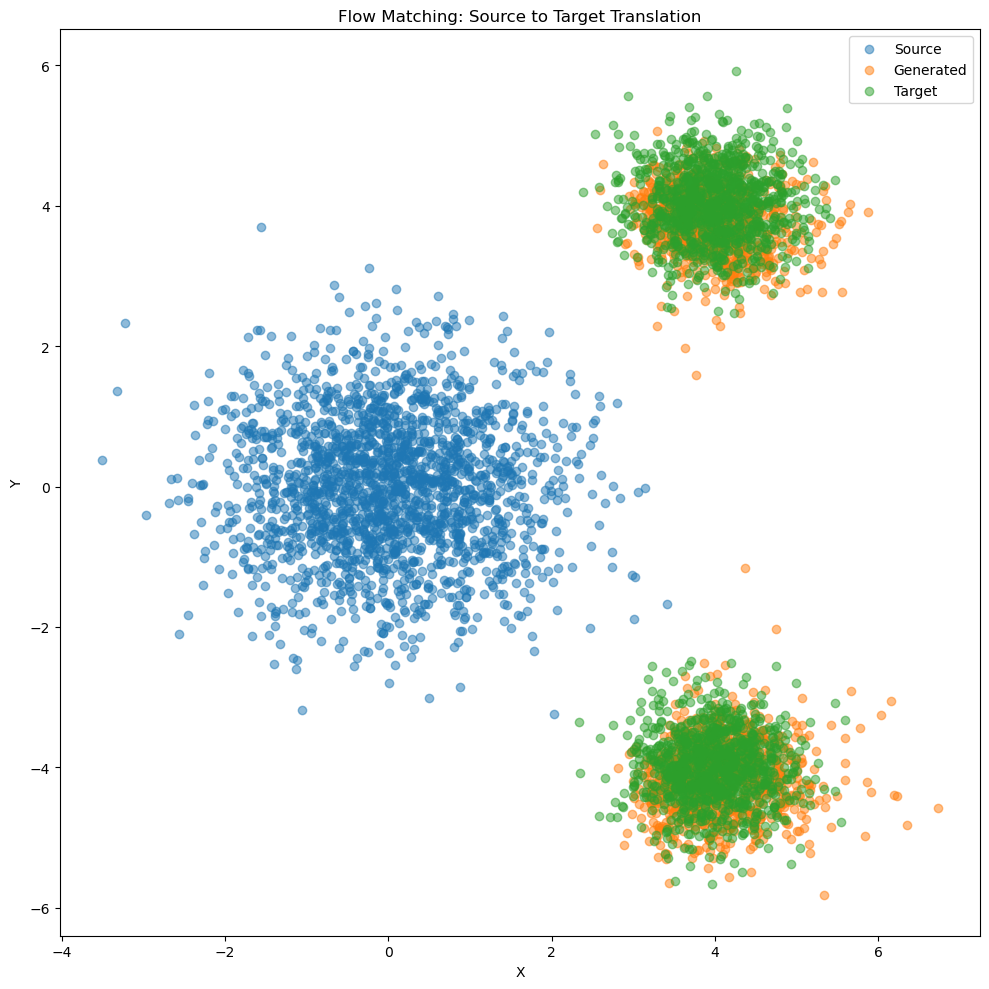

Flow Matching static result plot saved as 'flow_matching_static_result.png'


In [51]:

def static_sample(model, num_samples, device, source_samples, num_steps=100):
    # Convert source samples to tensor and move to device
    x = torch.tensor(source_samples, dtype=torch.float32).to(device)
    
    # Time steps
    dt = 1 / num_steps

    with torch.no_grad():
        for frame in range(num_steps):
            t = torch.ones(num_samples, device=device) * (1 - frame * dt)
            t = t.unsqueeze(-1)
            v = model(x, t)
            x = x - v * dt

    return x.cpu().numpy()

# Generate final samples
final_samples = static_sample(model, 2000, device, source_samples)

# Plot the final result
plt.figure(figsize=(10, 10))
plt.scatter(source_samples[:, 0], source_samples[:, 1], alpha=0.5, label='Source')
plt.scatter(final_samples[:, 0], final_samples[:, 1], alpha=0.5, label='Generated')
plt.scatter(target_samples[:, 0], target_samples[:, 1], alpha=0.5, label='Target')
plt.legend()
plt.title("Flow Matching: Source to Target Translation")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()
# plt.savefig('flow_matching_static_result.png', dpi=300, bbox_inches='tight')
# plt.close()

print("Flow Matching static result plot saved as 'flow_matching_static_result.png'")


# Vector field to Score and Sampling with SDE

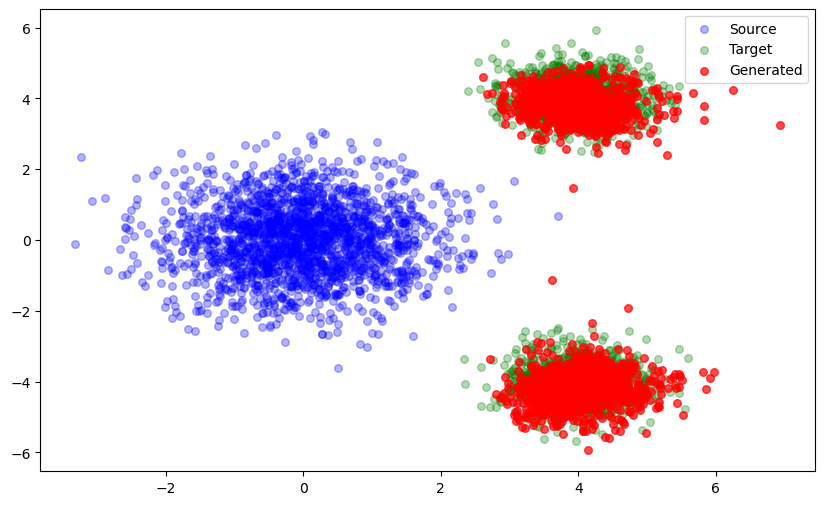

In [2]:

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch
import math

def get_score_from_velocity(velocity, x, t):
    t = t.unsqueeze(-1)
    alpha_t, d_alpha_t = compute_alpha_t(t)
    sigma_t, d_sigma_t = compute_sigma_t(t)
    alpha_ratio = d_alpha_t / alpha_t
    lambda_t = d_sigma_t - alpha_ratio * sigma_t
    score = (alpha_ratio * x - velocity) / (sigma_t * lambda_t)
    return score

def get_drift_and_diffusion(x, t):
    t = t.unsqueeze(-1)
    alpha_t, d_alpha_t = compute_alpha_t(t)
    sigma_t, d_sigma_t = compute_sigma_t(t)
    alpha_ratio = d_alpha_t / alpha_t
    drift = alpha_ratio * x
    lambda_t = d_sigma_t - alpha_ratio * sigma_t
    diffusion = 2 * sigma_t * lambda_t
    return drift, diffusion

def euler_step(x, mean_x, t, model, dt, sde=False):
    w_cur = torch.randn(x.size()).to(x)
    t = torch.ones(x.size(0)).to(x) * t
    dw = w_cur * math.sqrt(dt)
    drift, diffusion = get_drift_and_diffusion(x, t)
    
    if not sde:
        velocity = drift - 0.5 * diffusion * get_score_from_velocity(model(x, t.unsqueeze(-1)), x, t)
        mean_x = x - velocity * dt
        x = mean_x 
    else:
        reverse_drift = drift - diffusion * get_score_from_velocity(model(x, t.unsqueeze(-1)), x, t)
        mean_x = x - reverse_drift * dt
        x = mean_x - torch.sqrt(diffusion) * dw
    return x, mean_x

def custom_step(x, mean_x, t, model, dt):
    w_cur = torch.randn(x.size()).to(x)
    dw = w_cur * math.sqrt(dt)
    sigma_t, d_sigma_t = compute_sigma_t(t.unsqueeze(-1))
    velocity = model(x, t.unsqueeze(-1))
    score = get_score_from_velocity(velocity, x, t)
    drift = velocity - 0.5  * sigma_t * score 
    mean_x = x - drift * dt
    x = mean_x + torch.sqrt(sigma_t) * dw
    return x, mean_x


@torch.no_grad()
def sample_sde_static(source_samples, model, device, steps=100, sde=False):
    model.eval()
    x = torch.tensor(source_samples, dtype=torch.float32).to(device)
    mean_x = x.clone()
    dt = 1.0 / steps
    
    for i in range(1, steps):
        t = torch.ones(x.size(0)).to(x) * (1 - i * dt)
        x, mean_x = euler_step(x, mean_x, t, model, dt, sde=sde)

    return x

# just plot the source, target and generated samples
source_samples = torch.randn(2000, 2).numpy()
target_samples = X.numpy()[:2000]

generated_samples = sample_sde_static(source_samples, model, device, steps=1000, sde=False)
plt.figure(figsize=(10, 6))
plt.scatter(source_samples[:, 0], source_samples[:, 1], s=30, c='blue', alpha=0.3, label='Source')
plt.scatter(target_samples[:, 0], target_samples[:, 1], s=30, c='green', alpha=0.3, label='Target')
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], s=30, c='red', alpha=0.7, label='Generated')
plt.legend()
plt.show()



In [35]:


@torch.no_grad()
def sample_sde(model, n_samples, device, source_samples, target_samples, steps=100):
    model.eval()
    x = torch.tensor(source_samples, dtype=torch.float32).to(device)
    mean_x = x.clone()
    dt = 1.0 / steps
    
    fig, ax = plt.subplots(figsize=(10, 10))
    scatter = ax.scatter([], [], s=25, c='red', alpha=0.7, label='Generated')
    source_scatter = ax.scatter(source_samples[:, 0], source_samples[:, 1], s=30, c='blue', alpha=0.3, label='Source')
    target_scatter = ax.scatter(target_samples[:, 0], target_samples[:, 1], s=30, c='green', alpha=0.3, label='Target')
    time_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, fontsize=20, horizontalalignment='left', verticalalignment='top')
    
    all_data = np.vstack((source_samples, target_samples))
    x_min, x_max = all_data[:, 0].min(), all_data[:, 0].max()
    y_min, y_max = all_data[:, 1].min(), all_data[:, 1].max()
    margin = 0.05 * max(x_max - x_min, y_max - y_min)
    ax.set_xlim(x_min - margin, x_max + margin)
    ax.set_ylim(y_min - margin, y_max + margin)
    
    ax.legend(loc='lower left', fontsize=20)
    ax.axis('off')
    lines = [ax.plot([], [], color='red', alpha=0.1, linewidth=0.5)[0] for _ in range(n_samples)]
    
    def update(frame):
        nonlocal x
        nonlocal mean_x

        if frame <= steps:
            t = torch.ones(n_samples, device=device) * max((1 - (frame + 1) * dt), dt)
            x, mean_x = euler_step(x, mean_x, t, model, dt, sde=True)
            time_text.set_text(f't = {(steps-frame)/steps}')
            scatter.set_offsets(x.cpu().numpy())
        for i, line in enumerate(lines):
            line.set_data([source_samples[i, 0], x[i, 0].cpu()], [source_samples[i, 1], x[i, 1].cpu()])
        
        return scatter, time_text, *lines
    
    anim = animation.FuncAnimation(fig, update, frames=steps+20, interval=50, blit=True)

    plt.tight_layout()
    anim.save('sde_sampling_process.gif', writer='pillow', fps=30)
    plt.close(fig)
    
    return x


# Generate source and target samples
source_samples = torch.randn(2000, 2).numpy()
target_samples = X.numpy()[:2000]

# Generate samples and create animation
samples = sample_sde(model, 2000, device, source_samples, target_samples, steps=100)

print("SDE sampling process animation saved as 'sde_sampling_process.gif'")


SDE sampling process animation saved as 'sde_sampling_process.gif'


In [49]:
@torch.no_grad()
def sample_sde(model, n_samples, device, source_samples, target_samples, steps=100):
    model.eval()
    x = torch.tensor(source_samples, dtype=torch.float32).to(device)
    mean_x = x.clone()
    dt = 1.0 / steps
    
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.title(r'Simulation using SDE with the score,  $s_t = \frac{\dot{\alpha}_t x - \alpha_t v_t}{ \alpha_t \sigma_t \lambda_t}$', fontsize=20, y=1.05, bbox=dict(facecolor='yellow', alpha=0.5, edgecolor='none'))

    scatter = ax.scatter([], [], s=25, c='red', alpha=0.7)
    source_scatter = ax.scatter(source_samples[:, 0], source_samples[:, 1], s=30, c='blue', alpha=0.3)
    target_scatter = ax.scatter(target_samples[:, 0], target_samples[:, 1], s=30, c='green', alpha=0.3)
    
    all_data = np.vstack((source_samples, target_samples))
    x_min, x_max = all_data[:, 0].min(), all_data[:, 0].max()
    y_min, y_max = all_data[:, 1].min(), all_data[:, 1].max()
    margin = 0.05 * max(x_max - x_min, y_max - y_min)
    ax.set_xlim(x_min - margin, x_max + margin)
    ax.set_ylim(y_min - margin, y_max + margin)
    
    ax.axis('off')
    lines = [ax.plot([], [], color='red', alpha=0.1, linewidth=0.5)[0] for _ in range(n_samples)]
    
    # Add time text at the bottom right
    # time_text = ax.text(0.95, 0.05, '', transform=ax.transAxes, fontsize=16, horizontalalignment='right', verticalalignment='bottom')
    time_text = ax.text(0.05, 0.05, '', transform=ax.transAxes, fontsize=20, horizontalalignment='left', verticalalignment='bottom',  
                        bbox=dict(facecolor='yellow', alpha=0.5, edgecolor='none')
                         )
    
    def update(frame):
        nonlocal x
        nonlocal mean_x

        if frame <= steps:
            t = torch.ones(n_samples, device=device) * max((1 - (frame + 1) * dt), dt)
            x, mean_x = euler_step(x, mean_x, t, model, dt, sde=True)
            scatter.set_offsets(x.cpu().numpy())
            # Update time text
            time_text.set_text(f't = {max(1 - (frame + 1) * dt, 0):.2f}')
        for i, line in enumerate(lines):
            line.set_data([source_samples[i, 0], x[i, 0].cpu()], [source_samples[i, 1], x[i, 1].cpu()])
        
        return scatter, time_text, *lines
    
    anim = animation.FuncAnimation(fig, update, frames=steps+20, interval=50, blit=True)

    plt.tight_layout()
    anim.save('sde_sampling_process_unlabeled.gif', writer='pillow', fps=30)
    plt.close(fig)
    
    return x


# Generate source and target samples
source_samples = torch.randn(2000, 2).numpy()
target_samples = X.numpy()[:2000]

# Generate samples and create animation
samples = sample_sde(model, 2000, device, source_samples, target_samples, steps=100)
print("SDE sampling process animation saved as 'sde_sampling_process_unlabeled.gif'")


SDE sampling process animation saved as 'sde_sampling_process_unlabeled.gif'


In [52]:
from PIL import Image, ImageDraw, ImageFont
import os

def create_side_by_side_gif(gif1_path, gif2_path, output_path, title1="ODE", title2="SDE", extra_frames=30):
    # Open the GIF files
    gif1 = Image.open(gif1_path)
    gif2 = Image.open(gif2_path)

    # Get the number of frames (use the minimum if they differ)
    n_frames = min(gif1.n_frames, gif2.n_frames)

    # Create a list to store the new frames
    new_frames = []

    # Prepare the font
    font_size = 30
    font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", font_size)

    for i in range(n_frames):
        # Select the i-th frame from both GIFs
        gif1.seek(i)
        gif2.seek(i)
        
        # Create a new image with double the width
        new_img = Image.new('RGB', (gif1.width * 2, gif1.height))
        
        # Paste the frames side by side
        new_img.paste(gif1.copy(), (0, 0))
        new_img.paste(gif2.copy(), (gif1.width, 0))
        
        # Add text
        draw = ImageDraw.Draw(new_img)
        draw.text((10, 10), title1, font=font, fill=(255, 255, 255))
        draw.text((gif1.width + 10, 10), title2, font=font, fill=(255, 255, 255))
        
        new_frames.append(new_img)

    # Add extra stationary frames at the end
    last_frame = new_frames[-1]
    for _ in range(extra_frames):
        new_frames.append(last_frame.copy())

    # Save the new GIF
    new_frames[0].save(
        output_path,
        save_all=True,
        append_images=new_frames[1:],
        duration=1000 // 30,  # Set duration to display 30 frames per second
        loop=0
    )

# Paths to the GIFs
# ode_gif_path = "/Users/sagarshrestha/Projects/shresthasagar.github.io/assets/images/blogs/sol_fm_diff/flow_matching_process.gif"
ode_gif_path = "/Users/sagarshrestha/Projects/shresthasagar.github.io/flow_matching_process_titled.gif"


sde_gif_path = "/Users/sagarshrestha/Projects/shresthasagar.github.io/sde_sampling_process_unlabeled.gif"
# Output path
output_path = "combined_ode_sde_low_res.gif"

# Create the combined GIF with 30 extra frames at the end
create_side_by_side_gif(ode_gif_path, sde_gif_path, output_path, extra_frames=30)

print(f"Combined GIF saved as '{output_path}'")


FileNotFoundError: [Errno 2] No such file or directory: '/Users/sagarshrestha/Projects/shresthasagar.github.io/flow_matching_process_titled.gif'

In [55]:
from PIL import Image
import os

def reduce_gif_resolution(input_path, output_path, scale_factor=0.5, fps=30, extra_frames=20):
    # Open the GIF
    with Image.open(input_path) as img:
        # Get the original dimensions
        original_width, original_height = img.size
        
        # Calculate new dimensions
        new_width = int(original_width * scale_factor)
        new_height = int(original_height * scale_factor)
        
        # Create a list to store resized frames
        frames = []
        
        try:
            while True:
                # Copy the current frame
                frame = img.copy()
                
                # Resize the frame
                frame = frame.resize((new_width, new_height), Image.LANCZOS)
                
                # Append the resized frame to the list
                frames.append(frame)
                
                # Move to the next frame
                img.seek(img.tell() + 1)
        except EOFError:
            pass  # End of frames

        # Add extra static frames at the end
        last_frame = frames[-1]
        for _ in range(extra_frames):
            frames.append(last_frame.copy())

        # Calculate new duration for 30 fps
        duration = int(1000 / fps)  # Duration in milliseconds

        # Save the resized frames as a new GIF
        frames[0].save(
            output_path,
            save_all=True,
            append_images=frames[1:],
            optimize=True,
            duration=duration,
            loop=0
        )

# Input and output paths
input_gif = "/Users/sagarshrestha/Projects/shresthasagar.github.io/assets/images/blogs/sol_fm_diff/combined_ode_sde.gif"
output_gif = "/Users/sagarshrestha/Projects/shresthasagar.github.io/assets/images/blogs/sol_fm_diff/combined_ode_sde_low_res.gif"

# Reduce resolution, set to 30 fps, and add 20 static frames at the end
reduce_gif_resolution(input_gif, output_gif, fps=30, extra_frames=20)

print(f"Reduced resolution GIF with extra frames saved as '{output_gif}'")

# Compare file sizes
original_size = os.path.getsize(input_gif)
reduced_size = os.path.getsize(output_gif)

print(f"Original file size: {original_size / 1024:.2f} KB")
print(f"Reduced file size: {reduced_size / 1024:.2f} KB")
print(f"Size reduction: {(1 - reduced_size / original_size) * 100:.2f}%")


/var/folders/m6/2d5bkw9968v0xk11q0gpszhm0000gn/T/ipykernel_7348/1018480508.py:23: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  frame = frame.resize((new_width, new_height), Image.LANCZOS)


Reduced resolution GIF with extra frames saved as '/Users/sagarshrestha/Projects/shresthasagar.github.io/assets/images/blogs/sol_fm_diff/combined_ode_sde_low_res.gif'
Original file size: 29785.75 KB
Reduced file size: 14730.32 KB
Size reduction: 50.55%
